# Advanced Methods for Improving the Performance of Convolutional Neural Networks

CSC/DSC 340 Week 11 Slides

Author: [Dr. Julie Butler](http://www.juliebutler.org)

Date Created: October 29, 2023

Last Modified: October 29, 2023

* Last week we learned how to classify the MNIST data set with convolutional neural networks and how to improve the performance of these CNNs with hyperparameter tuning
* This week we will learn how to futher improve the performance using a few preprocessing techniques and a few different architecture styles

* First, let's review the MNIST data set

In [1]:
import tensorflow as tf

# Load MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

# Print the shape of the data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


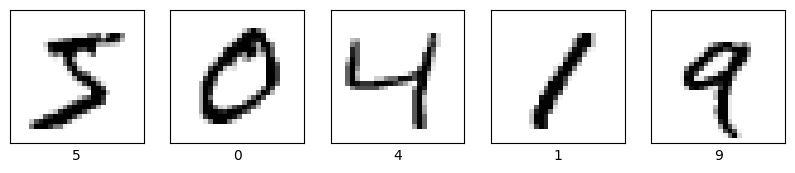

In [2]:
import matplotlib.pyplot as plt
# Display a small number of images
num_images = 5
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

* Now let's review how to classify the MNIST data set with a simple CNN

In [3]:
from tensorflow.keras import layers, models

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

del train_images
del test_images

Epoch 1/5
844/844 [==============================] - 17s 20ms/step - loss: 0.2010 - accuracy: 0.9379 - val_loss: 0.0659 - val_accuracy: 0.9803
Epoch 2/5
844/844 [==============================] - 21s 25ms/step - loss: 0.0547 - accuracy: 0.9829 - val_loss: 0.0395 - val_accuracy: 0.9885
Epoch 3/5
844/844 [==============================] - 18s 21ms/step - loss: 0.0379 - accuracy: 0.9881 - val_loss: 0.0373 - val_accuracy: 0.9898
Epoch 4/5
844/844 [==============================] - 18s 22ms/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.0352 - val_accuracy: 0.9908
Epoch 5/5
844/844 [==============================] - 21s 25ms/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.0379 - val_accuracy: 0.9893
313/313 - 1s - loss: 0.0373 - accuracy: 0.9868 - 1s/epoch - 4ms/step

Test accuracy: 0.9868000149726868


* Now let's attempt to improve this accuracy
    * NOTE: these techniques may not work well on the MNIST data set since the images are quite simple but will work better with larger and more complex images

## Improving Through Pre-Processing Steps

* First let's increase the size of the data set using _data augmentation_
    * Add images to the data set that are rotated, stretched, translated, and zoomed in versions of the original images
    * Should lead to better generalization and thus increased accuracy

* Note that for the `ImageDataGenerator` function the X data (the images) need to be four dimensions instead of 3 dimensions

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Data preprocessing and normalization
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

# Create a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with augmented data
model.fit(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) / 32, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

del x_train
del x_test


Epoch 1/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2803 - accuracy: 0.9118
Epoch 2/5
1207/1875 [==================>...........] - ETA: 9s - loss: 0.1032 - accuracy: 0.9681

KeyboardInterrupt: 

* Next we will attempt to increase the accuracy by sharpening the edges of the digits by removing pixels that are light grey
* For more complex images, there are algorithms for edge sharpening, deblurring, etc. that can be applied in a similar manner

In [ ]:
import numpy as np
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Function to remove gray images
def remove_gray_images(images, threshold=5):
    images_redone = []
    for image in images:
        for i in range(28):
            for j in range(28):
                if image[i][j] < 255-threshold:
                    image[i][j] = 0
        images_redone.append(image)
    images_redone = np.asarray(images_redone)
    return images_redone

# Remove gray images from the training set
x_train_filtered = remove_gray_images(x_train, 55)

# Remove gray images from the test set
x_test_filtered = remove_gray_images(x_test, 55)


* The original images

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Display a small number of images
num_images = 5
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

* The sharpened images

In [ ]:
# Display a small number of images
num_images = 5
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_filtered[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

* Now let's train a CNN using the sharpened data set

In [ ]:
# Scale the data
x_train_filtered = x_train_filtered / 255
x_test_filtered = x_test_filtered / 255

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train_filtered, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_filtered, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

del x_train
del x_test
del x_train_filtered
del x_test_filtered

## Improving Accuracy with Differing Architectures

* First we will test the addition of regularization and drop-out to the CNN
    * Regularization: Using L1 or L2 norms to control the values of the weights of the network (like LASSO and Ridge regresion)
    * Dropout: randomly setting X% of the weights of a layer to zero
* Both methods can reduce overfitting and thus increase accuracy

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

# Create a CNN model with regularization and dropout
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

del x_train
del x_test


* Ensemble Learning: Train many CNNs and take the average of the CNNS to be the result
    * Also used to reduce overfitting and capture various patterns in the data
* The ensemble can be made of CNNs of the same architecture (this example) or different architectures

In [25]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Create multiple CNN models
num_models = 5
models = []

for i in range(num_models):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    models.append(model)

# Train the models
for model in models:
    model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=0)
# Combine predictions from the models

y_preds = np.zeros_like(y_test)

for model in models:
    y_preds += model.predict(x_test)

y_preds /= num_models

# Convert to the prediction (instead of the probabilities)
y_pred = np.argmax(y_preds, axis=-1)
y_test = np.argmax(y_test, axis=-1)

from sklearn.metrics import accuracy_score

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))

del x_train
del x_test

313/313 [==============================] - 0s 1ms/step
Ensemble Accuracy: 0.9811


### More Complex Architecture
* Inception Networks, ResNet, DeepNet
    * Improve computational effeciency with smaller parallel layers instead of larger layers
* Can train the networks using Google's ImageNet weights (transfer learning)
* Not useful (in fact not appliciable) the MNIST data set but work well on larger image dta sets